# Reproduction Instructions

Others
1. Navigate to `/scripts/`
2. Execute `get_suburbs_shp.py`
3. Execute `/notebooks/PTVdataProcessing.ipynb`

House Speaking Same
1. Navigate to `/scripts/housespeakingsame`
2. Execute `scrape_house_speakingsame_suburbs.py`
3. Execute `preprocess_house_speakingsame_suburbs.py`
4. Execute `scrape_house_speakingsame_schools.py`

In [1]:
import pandas as pd
import geopandas as gpd
from glob import glob
import folium
from datetime import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt

TOP_SUB_DATA_DIR = "../data/curated/housespeakingsame/top/"
SCHOOLS_PATH = "../data/raw/housespeakingsame/schools/top_schools.csv"
PTV_PATH = '../data/curated/PTV_stations_count_by_suburb.csv'
shp_file = "../data/raw/suburbs/SAL_2021_AUST_GDA2020.shp"

/home/mark/anaconda3/envs/adsp2/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
sf = gpd.read_file(shp_file)
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
vic_sf = sf.query("STE_NAME21=='Victoria'")

In [3]:
sub_df = pd.DataFrame(columns = ['suburb'])
for p in glob(TOP_SUB_DATA_DIR + '*'):
    name = p.split('/')[-1].split('.')[0]
    d = pd.read_csv(p, index_col=0)[['suburb','rank','value']]
    d[name] = d['value']
    d[name + '_rank'] = d['rank']
    d = d.drop(['value', 'rank'], axis=1)
    sub_df = sub_df.merge(d, on='suburb', how='outer')
sub_df = sub_df.sort_values('rent_rank')

In [4]:
schools = pd.read_csv(SCHOOLS_PATH)

In [6]:
school_ranks = schools.groupby('suburb')['rank'].agg(['min','mean','max']).reset_index().set_index('suburb')
school_ranks.columns = ['school_rank_' + c for c in school_ranks.columns]
school_counts = schools.groupby('suburb')['type'].value_counts().reset_index(name='count').pivot('suburb','type','count').reset_index().fillna(0)
school_counts['total'] = school_counts.drop('suburb', axis=1).sum(axis=1)
school_counts = school_counts.sort_values('total').set_index('suburb')
school_counts.columns = ['schools_' + c for c in school_counts.columns]

/tmp/ipykernel_5452/3063215064.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  school_counts = schools.groupby('suburb')['type'].value_counts().reset_index(name='count').pivot('suburb','type','count').reset_index().fillna(0)


In [7]:
sub_schools = school_counts.merge(school_ranks, left_index=True, right_index=True, how='outer').reset_index()

In [8]:
ptv = pd.read_csv(PTV_PATH, index_col=0).fillna(0)
ptv['suburb'] = ptv['suburb'].str.lower().str.capitalize()

In [9]:
ptv.columns = ['suburb', 'Train', 'Tram', 'Bus', 'Total Stations']

In [10]:
sub = sub_df.merge(sub_schools, on='suburb', how='outer').merge(ptv, on='suburb', how='left')

In [11]:
fill0_cols = ['rented', 'education', 'turnover', 'owned', 'houses', 'occupation',
              'flats', 'purchased', 'schools_Combined', 'schools_Primary', 'schools_Secondary',
              'schools_total', 'Train', 'Tram', 'Bus', 'Total Stations']
sub[fill0_cols] = sub[fill0_cols].fillna(0)
sub = sub.rename({'suburb': 'Suburb'}, axis=1)

# Analyses

## Public Transport

<AxesSubplot:title={'center':'Suburbs with Top 10 Total PTV Station Counts'}, ylabel='Suburb'>

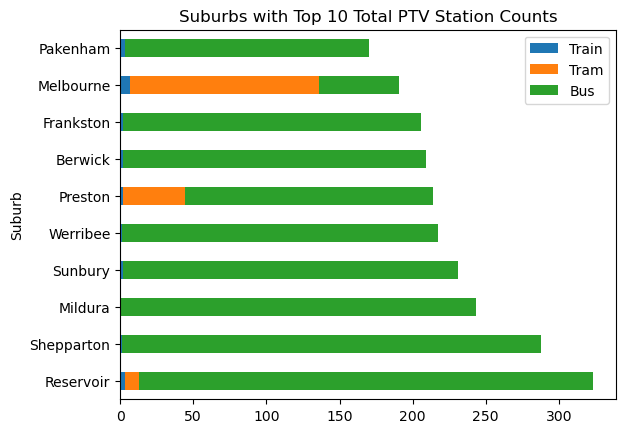

In [12]:
sub.nlargest(10, 'Total Stations')[['Suburb','Train','Tram','Bus','Total Stations']].plot(
    kind='barh', x='Suburb', y=['Train','Tram','Bus'], stacked=True, title='Suburbs with Top 10 Total PTV Station Counts')

<AxesSubplot:title={'center':'Suburbs with Top 10 Tram Station Counts'}, ylabel='Suburb'>

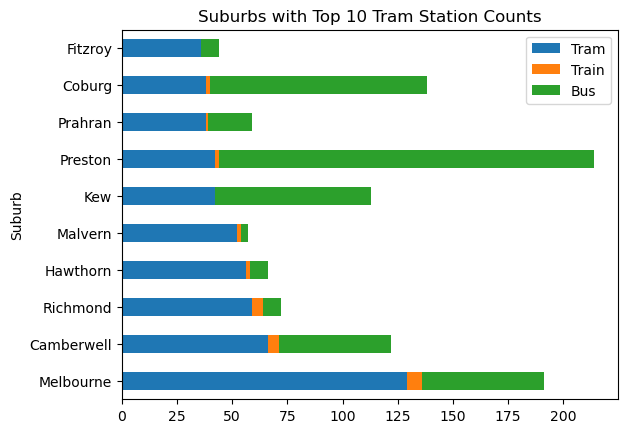

In [13]:
sub.nlargest(10, 'Tram')[['Suburb','Train','Tram','Bus','Total Stations']].plot(
    kind='barh', x='Suburb', y=['Tram','Train','Bus'], stacked=True, title='Suburbs with Top 10 Tram Station Counts')

## Education

In [30]:
sub.columns

Index(['Suburb', 'education', 'education_rank', 'occupation',
       'occupation_rank', 'turnover', 'turnover_rank', 'rent', 'rent_rank',
       'purchased', 'purchased_rank', 'owned', 'owned_rank', 'sold',
       'sold_rank', 'flats', 'flats_rank', 'rented', 'rented_rank', 'houses',
       'houses_rank', 'income', 'income_rank', 'schools_Combined',
       'schools_Primary', 'schools_Secondary', 'schools_total',
       'school_rank_min', 'school_rank_mean', 'school_rank_max', 'Train',
       'Tram', 'Bus', 'Total Stations'],
      dtype='object')

In [15]:
educ = sub[['Suburb', 'education', 'education_rank', 'schools_Combined', 'schools_Primary',
       'schools_Secondary', 'schools_total', 'school_rank_min',
       'school_rank_mean', 'school_rank_max']].copy()
educ.columns = ['Suburb', 'Tertiary', 'Tertiary Rank', 'Combined', 'Primary',
       'Secondary', 'Schools', 'HS Rank (min)',
       'HS Rank (avg)', 'HS Rank (max)']
educ.nlargest(10, 'Tertiary')

,Suburb,Tertiary,Tertiary Rank,Combined,Primary,Secondary,Schools,HS Rank (min),HS Rank (avg),HS Rank (max)
68,Parkville,51.0,1.0,0.0,0.0,1.0,1.0,83.0,83.000000,83.0
88,Carlton,33.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1088,Carlton South,33.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
314,Melbourne,24.0,3.0,2.0,0.0,1.0,3.0,1.0,34.666667,79.0
127,North Melbourne,20.0,4.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
204,Southbank,20.0,4.0,0.0,0.0,1.0,1.0,61.0,61.000000,61.0
297,Clayton,20.0,4.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
396,Notting Hill,20.0,4.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
27,Princes Hill,19.0,5.0,0.0,0.0,1.0,1.0,86.0,86.000000,86.0
80,Carlton North,19.0,5.0,0.0,1.0,0.0,1.0,NaN,NaN,NaN


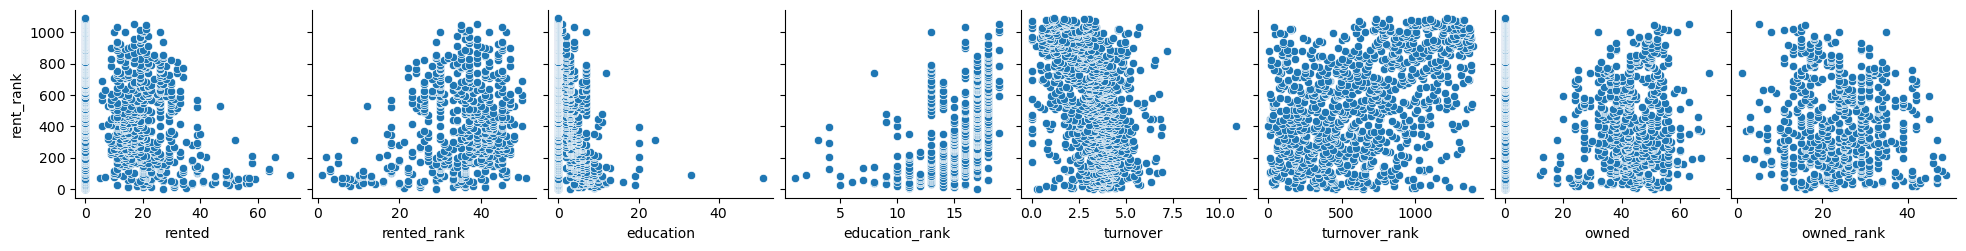

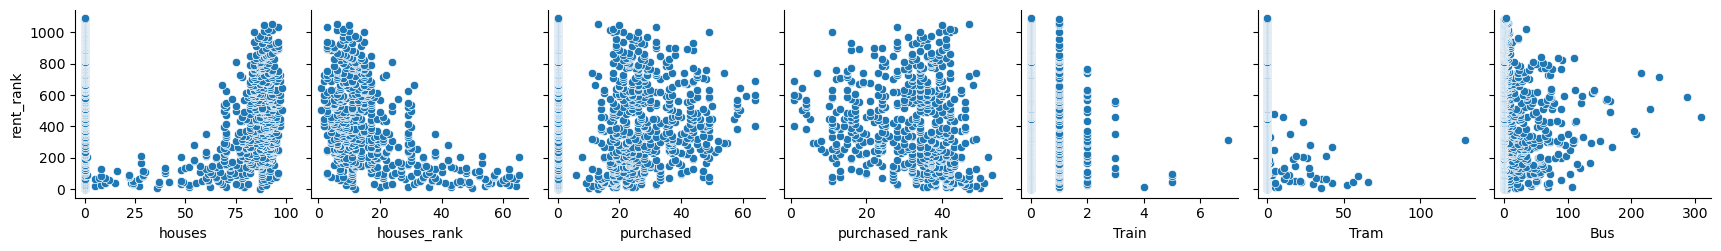

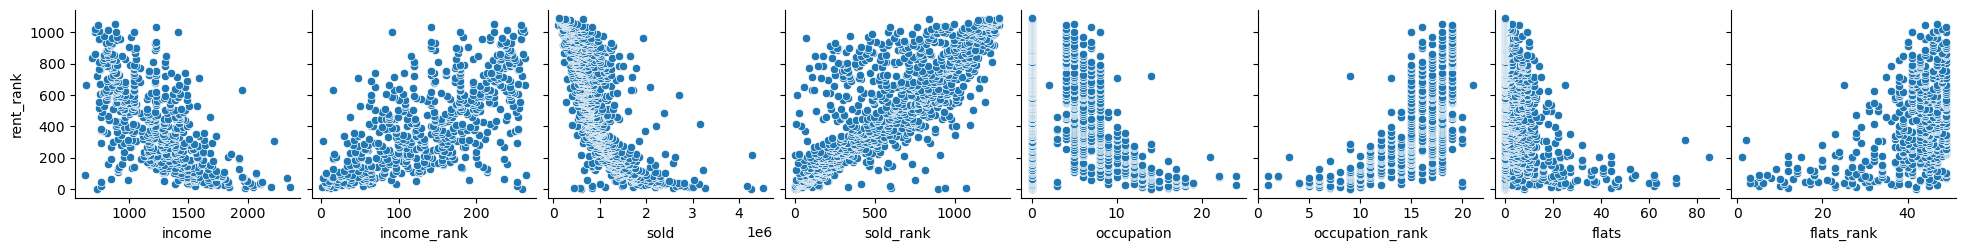

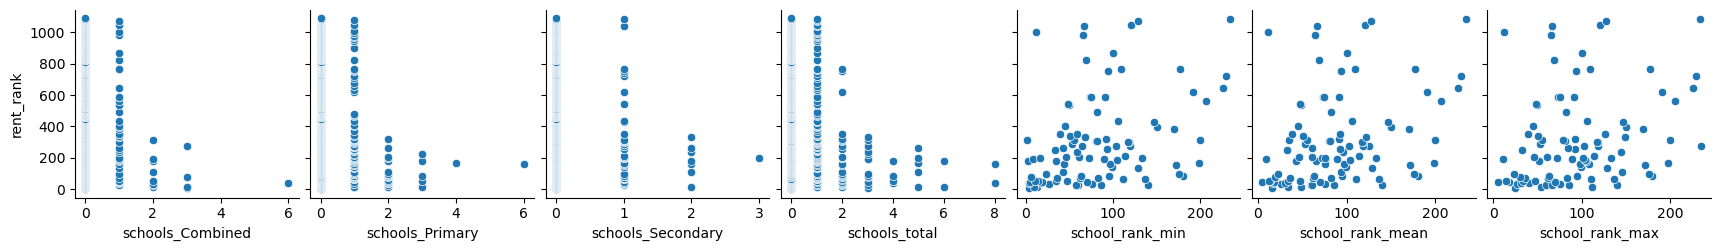

In [50]:
# fig, ax = plt.subplots(1,1,figsize=(20,5))
sns.pairplot(sub, x_vars=['rented', 'rented_rank', 'education', 'education_rank',
       'turnover', 'turnover_rank', 'owned', 'owned_rank'], y_vars = ['rent_rank'])
plt.show()

sns.pairplot(sub, x_vars=['houses', 'houses_rank', 'purchased', 'purchased_rank', 
                          'Train','Tram', 'Bus'], y_vars = ['rent_rank'])
plt.show()

sns.pairplot(sub, x_vars=['income', 'income_rank', 'sold', 'sold_rank', 
                          'occupation', 'occupation_rank', 'flats', 'flats_rank'
                         ], y_vars = ['rent_rank'])
plt.show()

sns.pairplot(sub, x_vars= ['schools_Combined', 'schools_Primary',
       'schools_Secondary', 'schools_total', 'school_rank_min',
       'school_rank_mean', 'school_rank_max'], y_vars = ['rent_rank'])
plt.show()

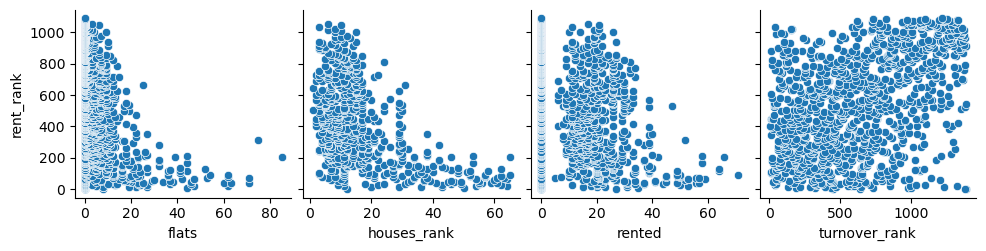

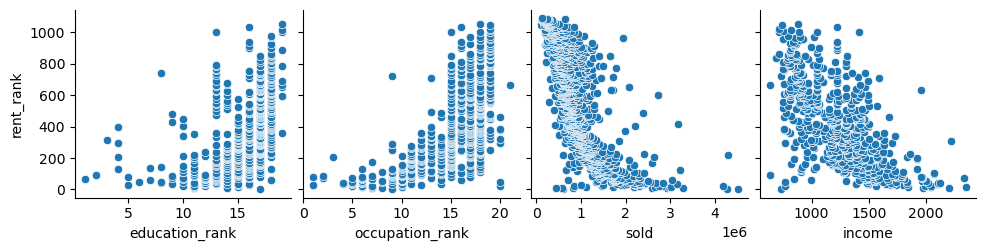

In [47]:
# useful features
sns.pairplot(sub, x_vars= ['flats', 'houses_rank',
       'rented', 'turnover_rank'], y_vars = ['rent_rank'])
plt.show()



sns.pairplot(sub, x_vars= ['education_rank',
       'occupation_rank', 'sold', 'income'], y_vars = ['rent_rank'])
plt.show()


<AxesSubplot:>

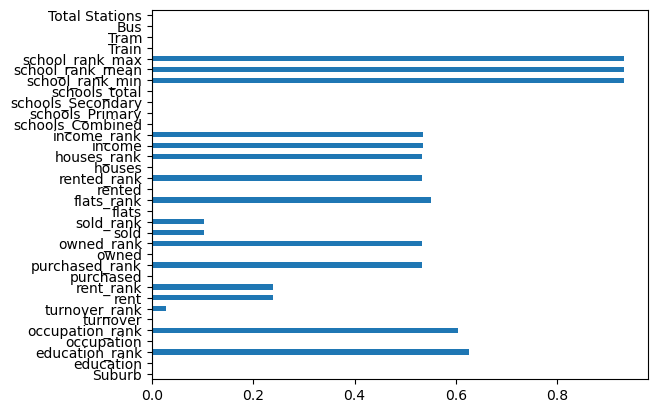

In [21]:
sub.isna().mean().plot.barh()

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline

clf = Pipeline([StandardScaler(), Lasso()])
# clf.fit()

In [44]:
sub.corr(method='spearman') ['rent'].sort_values()

/tmp/ipykernel_5452/378878450.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sub.corr(method='spearman') ['rent'].sort_values()


rent_rank           -1.000000
sold_rank           -0.768852
occupation_rank     -0.688014
income_rank         -0.644254
education_rank      -0.550609
turnover_rank       -0.417863
flats_rank          -0.417812
school_rank_min     -0.391608
school_rank_mean    -0.377390
school_rank_max     -0.325940
rented_rank         -0.189147
owned_rank           0.090641
Bus                  0.105931
Total Stations       0.128393
schools_Combined     0.163558
schools_Secondary    0.180270
purchased_rank       0.194463
Train                0.210301
Tram                 0.259771
schools_Primary      0.262820
houses               0.281618
schools_total        0.299000
purchased            0.359516
owned                0.373492
turnover             0.414539
rented               0.450785
houses_rank          0.455009
flats                0.507604
education            0.548901
occupation           0.567539
income               0.644254
sold                 0.768852
rent                 1.000000
Name: rent


moderate:
    flats               -0.507604
    houses_rank         -0.455009
    rented              -0.450785
    turnover_rank        0.417863
    education_rank       0.550609




strong: 
    occupation_rank      0.688014
    sold                -0.768852
    income              -0.644254

<AxesSubplot:>

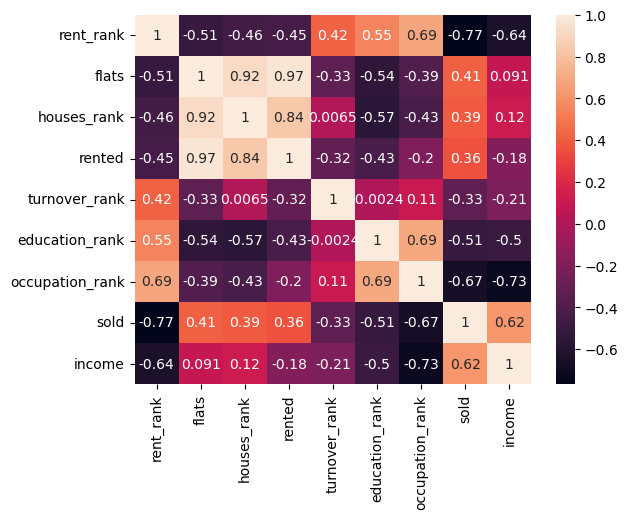

In [57]:
sub_useful = sub[['rent_rank','flats', 'houses_rank', 'rented', 'turnover_rank', 'education_rank', 
     'occupation_rank', 'sold', 'income']]

sns.heatmap(sub_useful.corr(method='spearman'), annot=True,transpar)

In [40]:
sub.corr(method='spearman') ['rent_rank'].sort_values()

/tmp/ipykernel_5452/820962962.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sub.corr(method='spearman') ['rent_rank'].sort_values()


rent                -1.000000
sold                -0.768852
income              -0.644254
occupation          -0.567539
education           -0.548901
flats               -0.507604
houses_rank         -0.455009
rented              -0.450785
turnover            -0.414539
owned               -0.373492
purchased           -0.359516
schools_total       -0.299000
houses              -0.281618
schools_Primary     -0.262820
Tram                -0.259771
Train               -0.210301
purchased_rank      -0.194463
schools_Secondary   -0.180270
schools_Combined    -0.163558
Total Stations      -0.128393
Bus                 -0.105931
owned_rank          -0.090641
rented_rank          0.189147
school_rank_max      0.325940
school_rank_mean     0.377390
school_rank_min      0.391608
flats_rank           0.417812
turnover_rank        0.417863
education_rank       0.550609
income_rank          0.644254
occupation_rank      0.688014
sold_rank            0.768852
rent_rank            1.000000
Name: rent

/tmp/ipykernel_13666/4120093332.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(sub.corr(method='spearman'))


<AxesSubplot:>

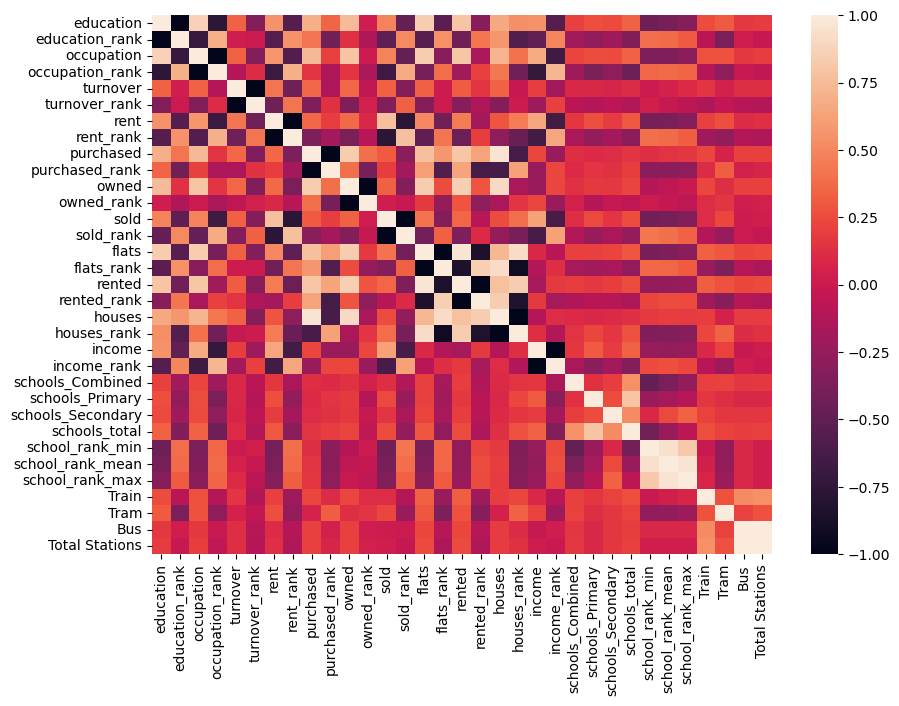

In [33]:
plt.subplots(1,1,figsize=(10,7))
sns.heatmap(sub.corr(method='spearman'))

In [43]:
schools_all = pd.read_excel('../data/raw/abs_data/education.xlsx', sheet_name = 3, skiprows = 4)

schools = schools_all.loc[schools_all['State/Territory'] == 'b Vic.']

In [44]:
schools

,Year,State/Territory,Affiliation (Gov/Non-gov),Affiliation (Gov/Cath/Ind),School Type,School Count
12,2021,b Vic.,a Government,a Government,a Primary school,1137.0
13,2021,b Vic.,a Government,a Government,b Secondary school,247.0
14,2021,b Vic.,a Government,a Government,c Combined school,82.0
15,2021,b Vic.,a Government,a Government,d Special school,81.0
16,2021,b Vic.,b Non-Government,b Catholic,a Primary school,394.0
...,...,...,...,...,...,...
1045,2010,b Vic.,b Non-Government,b Catholic,d Special school,8.0
1046,2010,b Vic.,b Non-Government,c Independent,a Primary school,46.0
1047,2010,b Vic.,b Non-Government,c Independent,b Secondary school,15.0
1048,2010,b Vic.,b Non-Government,c Independent,c Combined school,140.0
